### NNet Ratio

In [1]:
# import Ratio
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from Ratio import *

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.distributions as dist
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
import time
import ot
from pyhmc import hmc


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [3]:

# Load the data from the CSV file
MAGIC_data = pd.read_csv('magic.csv')
MAGIC_data = MAGIC_data[MAGIC_data.iloc[:, -1] == 'g']
selected_columns = ['fLength', 'Width', 'fConc', 'fM3Long', 'fM3Trans']
MAGIC_data = np.array(MAGIC_data[selected_columns])

torch.manual_seed(990109)
np.random.seed(990109)

seed = 990109

n_indep = 10

In [5]:
MAGIC_data.shape

(12332, 5)

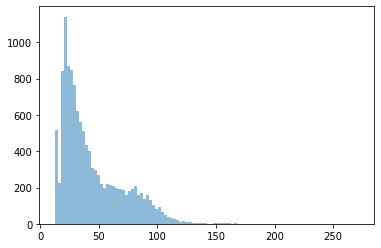

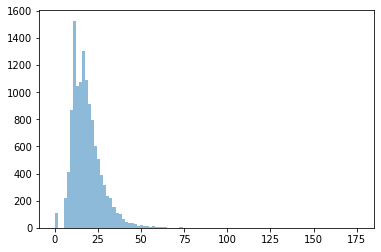

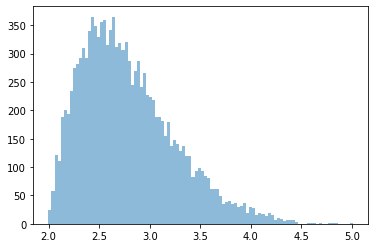

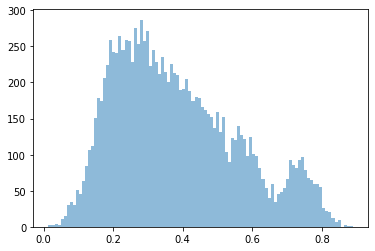

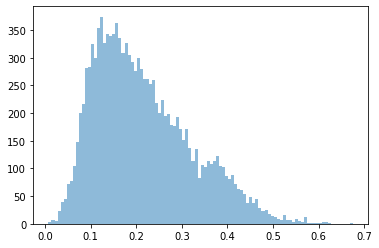

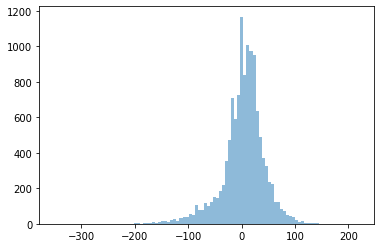

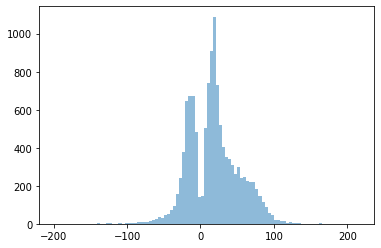

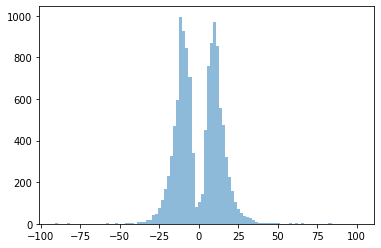

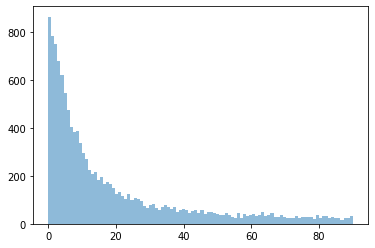

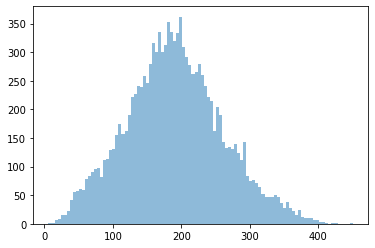

In [32]:
import matplotlib.pyplot as plt
for k in range(len(MAGIC_data[0])):
    plt.hist(MAGIC_data[:,k], bins=100, alpha=0.5)
    plt.show()

In [26]:
# Apply ECDF transformation
X_ecdf = np.zeros_like(MAGIC_data)
ecdf_list = []
for dim in range((MAGIC_data.shape[1])):
    ecdf = ECDF(MAGIC_data[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(MAGIC_data[:, dim]), 1e-6, 1 - 1e-6)

# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)
# Convert to PyTorch tensors
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32)
# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=seed)
# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

In [21]:
MAGIC_data.shape[0]

19020

In [10]:
from tqdm import tqdm

In [28]:
train_ratio_model = True



if train_ratio_model:
    # Define model
    ratio_model = Ratio(h_dim=100, in_dim=10, h_layers=2, normalising_cst = True, c = 1.0)

    # training loop for ####  GG Ratio  ####

    # Define loss function and optimizer
    optimizer = torch.optim.Adam(
            [{'params': [param for param in ratio_model.parameters() if param is not ratio_model.c]},
            {'params': [ratio_model.c], 'lr': 0.001}]  # Adjust the learning rate for ratio.c here
        )

    num_epochs = 51

    GG_cov = np.cov(X_train.reshape(-1,10).T)

    for epoch in tqdm(range(num_epochs)):
        ratio_model.train()
        running_loss = 0.0
        noise_index = 0 
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            r_p = ratio_model(inputs).squeeze()
            r_q = ratio_model(torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(10), cov=GG_cov, size=n_indep*inputs.shape[0])).float()).squeeze()
            noise_index += inputs.shape[0]
            loss = loss_nce(r_p, r_q,inputs.shape[0], n_indep*inputs.shape[0])
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, c: {ratio_model.c.item()}")
    # save the model
    #filename = f'GGNNet_{n_indep}_digits_seed_{seed}.pth'
    #torch.save(ratio_model.state_dict(), filename)

else: # load the pre-trained model
    filename = f'GGNNet_{n_indep}_digits_seed_{seed}.pth'
    ratio_model = Ratio_Simple()
    ratio_model.load_state_dict(torch.load(filename))

ratio_model.eval()


 20%|█▉        | 10/51 [00:07<00:30,  1.36it/s]

Epoch 10/51, Loss: 1.727375956873099, c: 0.992900550365448


 39%|███▉      | 20/51 [00:14<00:23,  1.33it/s]

Epoch 20/51, Loss: 1.5674748544891675, c: 0.98805171251297


 59%|█████▉    | 30/51 [00:22<00:16,  1.31it/s]

Epoch 30/51, Loss: 1.4926831449071567, c: 0.9842197895050049


 78%|███████▊  | 40/51 [00:29<00:08,  1.29it/s]

Epoch 40/51, Loss: 1.4362997983892758, c: 0.9797634482383728


 98%|█████████▊| 50/51 [00:36<00:00,  1.35it/s]

Epoch 50/51, Loss: 1.4071091040968895, c: 0.9773656129837036


100%|██████████| 51/51 [00:37<00:00,  1.34it/s]


Ratio(
  (fc_in): Linear(in_features=10, out_features=100, bias=True)
  (fc_hidden): Linear(in_features=100, out_features=100, bias=True)
  (fc_out): Linear(in_features=100, out_features=1, bias=True)
)

In [30]:
# LL computation

ratio_model.eval()
X_train_flat = X_train.reshape(-1, 10)
X_test_flat = X_test.reshape(-1, 10)
GG_cov = np.cov(X_train_flat.T)
# Define the multivariate normal distribution with the given covariance matrix
GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(10), covariance_matrix=GG_cov_tensor)
# Define the standard normal distribution
standard_normal = dist.Normal(loc=0, scale=1)
# Compute logpdf for the multivariate normal distribution
logpdf_multivariate_train = multivariate_normal.log_prob(X_train_flat)
logpdf_multivariate_test = multivariate_normal.log_prob(X_test_flat)
# Compute logpdf for the standard normal distribution and sum over the dimensions
logpdf_standard_train = standard_normal.log_prob(X_train_flat).sum(dim=1)
logpdf_standard_test = standard_normal.log_prob(X_test_flat).sum(dim=1)
# Compute GG_correction
GG_correction_train = logpdf_multivariate_train - logpdf_standard_train
GG_correction_test = logpdf_multivariate_test - logpdf_standard_test
# Compute means
mean_GG_correction_train = GG_correction_train.mean()
mean_GG_correction_test = GG_correction_test.mean()

# Compute GG ratio alone
gg_ratio_train = ratio_model(X_train).log().mean()
gg_ratio_test = ratio_model(X_test).log().mean()

# Compute GG ratio corrected
gg_ratio_corrected_train = (GG_correction_train + ratio_model(X_train).log()).mean()
gg_ratio_corrected_test = (GG_correction_test + ratio_model(X_test).log()).mean()

# Print the results
print('GG ratio alone', gg_ratio_train.item(), gg_ratio_test.item())
print('GG ratio corrected ; GG_ratio full', gg_ratio_corrected_train.item(), gg_ratio_corrected_test.item())


GG ratio alone 2.659236431121826 2.4405224323272705
GG ratio corrected ; GG_ratio full 6.6446661949157715 6.447673797607422


In [36]:
import scipy.stats as scs
# HMC

def sample_GG_hmc(GG_ratio_model, num_samples, num_runs_hmc, num_burnin):
    ''' 
    Sample from the ratio model with HMC.
    
    args:
        GG_ratio_model: nn.Module - the GG ratio copula model
        num_samples: int - the number of samples to generate per HMC run
        num_runs_hmc: int - the number of HMC runs, each giving num_samples draws
        num_burnin: int - the number of burn-in steps for a single HMC run
    
    returns:
        samples,log_pdf with
        samples: np.array - the generated samples of shape (num_runs_hmc*num_samples, 10)
        log_pdf: np.array - the log-pdf of the samples of shape (num_runs_hmc*num_samples,)
    '''
    GG_ratio_model.eval()
    def log_GGratio_gauss(x):
        ''' 
        Compute the log-pdf of the GG_ratio copula model and its gradient at x. 
        Takes the ratio model and adjusts it by the GG factor to make it into a copula.
        '''
        # compute the top part of a GG_ratio copula logpdf and the gradients of that
        x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        x_flat = x_tensor.reshape(-1, 10)
        # define N(Sigma) and N(0,1), then compute on x
        GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
        multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(10), covariance_matrix=GG_cov_tensor)
        standard_normal = dist.Normal(loc=0, scale=1)
        logpdf_multivariate = multivariate_normal.log_prob(x_flat)
        logpdf_standard = standard_normal.log_prob(x_flat).sum(dim=1)
        gg_correction = logpdf_multivariate - logpdf_standard
        # Compute the log of the ratio model
        log_ratio = torch.log(GG_ratio_model(x_tensor)).sum()
        # Compute the log probability of x under the standard normal distribution
        log_prob_standard = standard_normal.log_prob(x_tensor).sum()
        # Compute the final function value
        fun = log_ratio + gg_correction + log_prob_standard
        # Backward pass to compute the gradient
        fun.backward()
        grad_wrt_x = x_tensor.grad.reshape(1, -1)[0]
        
        return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

    samples = np.zeros((num_runs_hmc, num_samples, 10))
    log_pdf = np.zeros((num_runs_hmc, num_samples))
    x0_noise = np.zeros((num_runs_hmc,10))
    for hmc_run in tqdm( range(num_runs_hmc)):

        '''# pick x0 with highest r(x0) from random noise
        x0_proposal = torch.randn(1000, 1, 8, 8)
        r_noise = model(x0_proposal)
        x0_run = x0_proposal[np.argmax(r_noise.detach().numpy().flatten())]    
        '''
        # pick x0 randomly from N(0,1) 
        x0_run = torch.randn(1, 10)
        '''GG_cov = np.cov(X_train.reshape(-1,10).T)
        x0_run_np = scs.multivariate_normal.rvs(mean=np.zeros(10), cov=GG_cov, size=1).reshape(1,1,8,8)
        x0_run = torch.tensor(x0_run_np, dtype=torch.float32)'''
        samples_, log_pdf_ = hmc(log_GGratio_gauss,
                            x0=x0_run.flatten().numpy(),
                            n_samples=num_samples,
                            return_logp=True,
                            n_burn=num_burnin)
        
        samples[hmc_run] = samples_
        log_pdf[hmc_run] = log_pdf_
        x0_noise[hmc_run] = x0_run

    return samples.reshape(-1,10), log_pdf.reshape(-1), x0_noise

samples_simpleGG, log_pdf, x0_noises = sample_GG_hmc(GG_ratio_model=ratio_model, 
                            num_samples=1, 
                            num_runs_hmc=50,
                            num_burnin=100)
print(samples_simpleGG.shape)

# Save the samples and log probabilities
#np.save(f'GGNNet_HM100burnin_N01_{n_indep}_{seed}_samples_digits.npy', samples_simpleGG)

100%|██████████| 50/50 [00:25<00:00,  2.00it/s]


(50, 10)
tensor(1.9952) GG+Netratio 100hmc
tensor(2.1060) true obs
tensor(2.3026) gaussian
tensor(2.9598) random
(10, 990109, True)


NameError: name 'start' is not defined

(array([0.00135562, 0.01057385, 0.06290086, 0.20212326, 0.36574685,
        0.36710248, 0.20008983, 0.06642547, 0.01152279, 0.00135562]),
 array([-3.87838435, -3.10270739, -2.32703066, -1.55135369, -0.77567685,
         0.        ,  0.77567685,  1.55135369,  2.32703066,  3.10270739,
         3.87838435]),
 <BarContainer object of 10 artists>)

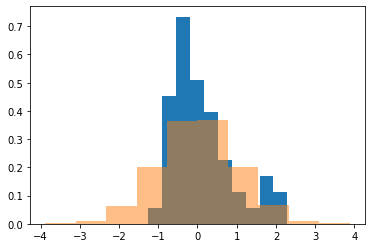

In [45]:
import matplotlib.pyplot as plt
plt.hist(samples_simpleGG[:,0],density=True)
plt.hist(X_train[:,0].numpy(), alpha=0.5, density=True)

In [37]:
# assess sample quality

def W2(x,y):
    return torch.sqrt(ot.emd2(torch.ones(x.shape[0])/x.shape[0], torch.ones(y.shape[0])/y.shape[0], ot.dist(x, y)))

print(W2(X_test.reshape(-1,10).float(),torch.tensor(samples_simpleGG).float()),'GG+Netratio 100hmc') 
print(W2(X_test.reshape(-1,10).float(),X_train.reshape(-1,10).float()[:50]),'true obs')
print(W2(X_test.reshape(-1,10).float(),torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(10), cov=GG_cov, size=500)).float()[:50]),'gaussian')
print(W2(X_test.reshape(-1,10).float(),torch.randn(500,10).float()[:50]),'random')

print((n_indep,seed,train_ratio_model))

print('Time:', time.time()-start)

tensor(1.9952) GG+Netratio 100hmc
tensor(2.1060) true obs
tensor(2.2983) gaussian
tensor(2.9949) random
(10, 990109, True)


NameError: name 'start' is not defined

### IGC vine and Gaussian

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.distributions as dist
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchsummary import summary
import numpy as np
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
import time
import ot
from pyhmc import hmc
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as scs
from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import pyvinecopulib as pv
import pandas as pd

In [4]:
def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 

def W2(x,y):
    return torch.sqrt(ot.emd2(torch.ones(x.shape[0])/x.shape[0], torch.ones(y.shape[0])/y.shape[0], ot.dist(x, y)))


In [5]:
MAGIC_data = pd.read_csv('magic.csv')
MAGIC_data = np.array(MAGIC_data.iloc[:,:-1])
torch.manual_seed(990109)
np.random.seed(990109)

seed = 990109

n_indep = 10

In [6]:
# Apply ECDF transformation
X_ecdf = np.zeros_like(MAGIC_data)
ecdf_list = []
for dim in range((MAGIC_data.shape[1])):
    ecdf = ECDF(MAGIC_data[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(MAGIC_data[:, dim]), 1e-6, 1 - 1e-6)

# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)
# Convert to PyTorch tensors
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32)
# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=seed)

In [7]:

class SoftRank(nn.Module):
    """Differentiable ranking layer"""
    def __init__(self, alpha=1000.0):
        super(SoftRank, self).__init__()
        self.alpha = alpha # constant for scaling the sigmoid to approximate sign function, larger values ensure better ranking, overflow is handled properly by PyTorch

    def forward(self, inputs):
        # input is a ?xSxD tensor, we wish to rank the S samples in each dimension per each batch
        # output is  ?xSxD tensor where for each dimension the entries are (rank-0.5)/N_rank
        x = inputs.unsqueeze(-1) #(?,S,D) -> (?,S,D,1)
        x_2 = x.repeat(1, 1, 1, x.shape[1]) # (?,S,D,1) -> (?,S,D,S) (samples are repeated along axis 3, i.e. the last axis)
        x_1 = x_2.transpose(1, 3) #  (?,S,D,S) -> (?,S,D,S) (samples are repeated along axis 1)
        return torch.transpose(torch.sum(torch.sigmoid(self.alpha*(x_1-x_2)), dim=1), 1, 2)/(torch.tensor(x.shape[1], dtype=torch.float32))


class IGC(nn.Module):
    
    def __init__(self, hidden_size=100, layers_number=2, output_size=2):
        super(IGC, self).__init__()
        self.dim_latent = 3 * output_size
        self.hidden_size = hidden_size
        self.layers_nuber = layers_number
        self.output_size = output_size
        self.linear_in = nn.Linear(in_features=self.dim_latent, out_features=self.hidden_size) 
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.hidden_size)
        self.linear_out = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)
        self.marginal_cdfs = None
        self.ecdf_10e6_samples = None

    def forward_train(self, z):
        '''
        Input noise z with shape (M,dim_latent)\\
        Outputs (u,v) pairs with shape (M,output_size=2), while ensuring u and v each have uniform marginals.
        '''
        y = torch.relu(self.linear_in(z))
        for layer in range(self.layers_nuber):
            y = torch.relu(self.linear(y))
        y = self.linear_out(y).unsqueeze(0)
        u = SoftRank()(y).squeeze(0)
        return u
        
    def Energy_Score_pytorch(self,beta, observations_y, simulations_Y):
        n = len(observations_y)
        m = len(simulations_Y)

        # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
        diff_Y_y = torch.pow(
            torch.norm(
                (observations_y.unsqueeze(1) -
                simulations_Y.unsqueeze(0)).float(),
                dim=2,keepdim=True).reshape(-1,1),
            beta)

        # Second part |Y-Y'|. 2* because pdist counts only once.
        diff_Y_Y = 2 * torch.pow(
            nn.functional.pdist(simulations_Y),
            beta)
        Energy = 2 * torch.mean(diff_Y_y) - torch.sum(diff_Y_Y) / (m * (m - 1))
        return Energy


    def forward(self, n_samples):
        ''' 
        Function to sample from the copula, once training is done.

        Input: n_samples - number of samples to generate
        Output: torch.tensor of shape (n_samples, output_size) on copula space.
        '''
        with torch.no_grad():
            if self.marginal_cdfs is None:
                self.marginal_cdfs = []
                # sample 10^6 points from the latent space and compute empirical marginal cdfs
                z = torch.randn(10**6, self.dim_latent)
                y = torch.relu(self.linear_in(z))
                for layer in range(self.layers_nuber):
                    y = torch.relu(self.linear(y))
                y = self.linear_out(y) # samples used to approximate cdfs
                for dim in range(y.shape[1]):
                    ecdf = ECDF(y[:, dim].numpy())
                    self.marginal_cdfs.append(ecdf)
                self.ecdf_10e6_samples = y
            # sample the latent space and apply ecdfs
            z = torch.randn(n_samples, self.dim_latent)
            y = torch.relu(self.linear_in(z))
            for layer in range(self.layers_nuber):
                y = torch.relu(self.linear(y))
            y = self.linear_out(y)
            for dim in range(y.shape[1]):
                y[:, dim] = torch.tensor(self.marginal_cdfs[dim](y[:, dim].numpy()), dtype=torch.float32)
            return y


In [ ]:

# make training data on 0-1 scale
X_train_cop = torch.tensor(scs.norm.cdf(X_train.reshape(-1,10)),dtype=torch.float32).clip(1e-5,1-1e-5)

# training loop
igc_cop = IGC(hidden_size=100, layers_number=2, output_size=10)

u_obs = X_train_cop

optimizer = torch.optim.Adam(igc_cop.parameters())
loss_hist = []

for i in tqdm(range(501)):
    optimizer.zero_grad()
    u = igc_cop.forward_train(torch.randn((200, igc_cop.dim_latent)))
    loss = igc_cop.Energy_Score_pytorch(1, u_obs[np.random.choice(range(u_obs.shape[0]),100,replace=True)], u)
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())

# save the model
torch.save(igc_cop.state_dict(), f'igc_cop{seed}.pth')
# sample
samples_cdf = igc_cop.forward(500).detach().numpy()
# save the samples
np.save(f'samples_igc{seed}.npy',samples_cdf)
print((W2(X_test.reshape(-1,64).float(),torch.tensor(scs.norm.ppf(samples_cdf)).float(),),'IGC'))
